# Lithofacies Classification Model

The purpose of this model was to showcase capabilities in working with seismic data, including pre-processing seismic data, creating labels and masks, creating predictions, and building re-usable infrastructure that can be used across models we plan to build.

To do this, we created a lithofacies classification U-Net model, which is half of model 4 in our workplan. This model uses F3 Netherlands open source seismic reflection data acquired in the north sea to predict the lithofacies in the data in 2D, providing valuable geology information for our ensemble model. With more data, this model can be readily extended to work in 3D on seismic cubes instead of just 2D patches and can have improved performance.

For more information:
- notebooks/Training.ipynb for training routine
- models/CNNs for the U-Net architecture
- utils for programs to read, write, alter .segy files to .npy for use with model building
- models for other model architecture we plan to implement
- geophysics to compute DHI, conduct basic AVO to create interpretations to be labeled

In [ ]:
##########
# Imports
##########
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
%matplotlib widget
sys.path.append('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/Seismic_AI')
from utils.utils import load_config
from keras.models import load_model
from utils.patch import  PatchGeneratorPredict
from utils.visualizations import vlm_slicer_interactive,vlm_slicer_interactive2
from scripts.predict import make_predictions_unet
from utils.visualizations import reconstruct_from_patches, plot_original_and_reconstructed, plot_sections

In [2]:
# Configs
config = load_config('../config/configs.yaml')
dataset_path2 = config['paths']['test_dataset2']
labels_path2 = config['paths']['test_dataset2_labels']
dataset_path1 = config['paths']['test_dataset1']
labels_path1 = config['paths']['test_dataset1_labels']
model_path = config['paths']['trained_model']

## Load out test data we want to run predictions on

In [3]:
###############################
# Load testing data and labels
###############################

# test dataset 1
test1_seismic = np.load(dataset_path1)
test1_labels = np.load(labels_path1)

test2_seismic = np.load(dataset_path2)
test2_labels = np.load(labels_path2)

# print geometry of data, with inline, crossline, and depth
print(f"Number of inline slices: {test2_seismic.shape[0]}")
print(f"Number of crossline slices: {test2_seismic.shape[1]}")
print(f"Depth dimension : {test2_seismic.shape[2]}")

Number of inline slices: 601
Number of crossline slices: 200
Depth dimension : 255


## Load our model, trained in training.ipynb

In [4]:
###########################
# Load the pretrained model
###########################
loaded_modelV2 = load_model(model_path)

## Generate predictions

In [5]:
###############################
# prediction dataset generation
###############################

patch_size = (128, 128)
stride = (64, 64)
processor = PatchGeneratorPredict(patch_size, stride)
predict_dataset2V5 = processor.create_datasets(test2_seismic) 
# Make predictions
predicted_lithofaciesV3 = make_predictions_unet(loaded_modelV2, predict_dataset2V5) 

128/128 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step


## Visualizations

Visualizations can be used to check performance. The model performance on unseen data was evaluated in training.ipynb, with 88-90% pixel accuracy reached. The model needs significantly more training in order to better classify the smaller classes that are found at deeper depths.

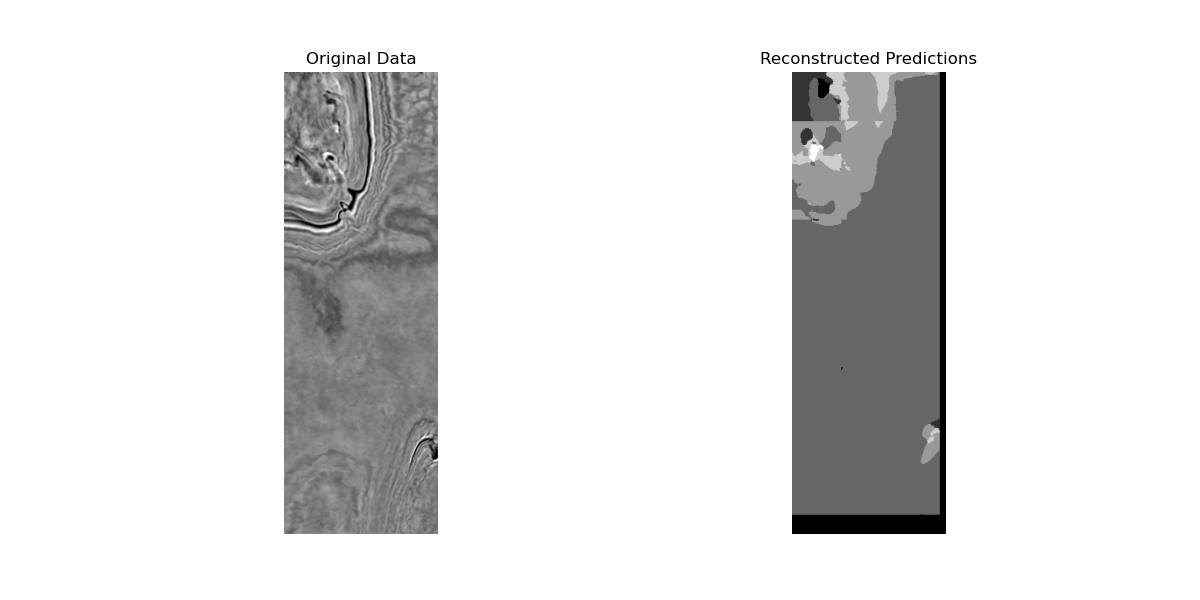

In [16]:
######################################
# visualize output predictions - depth
######################################

patch_size = (128, 128)
stride = (64, 64)  # Non-overlapping if (128,128)
original_shape = (601, 200,255)  # Example shape
depth_slice = 210 # Example depth slice to view

reconstructed_volume_depth = reconstruct_from_patches(predicted_lithofaciesV3, original_shape, patch_size, stride)
plot_original_and_reconstructed(test2_seismic, reconstructed_volume_depth, depth_slice)

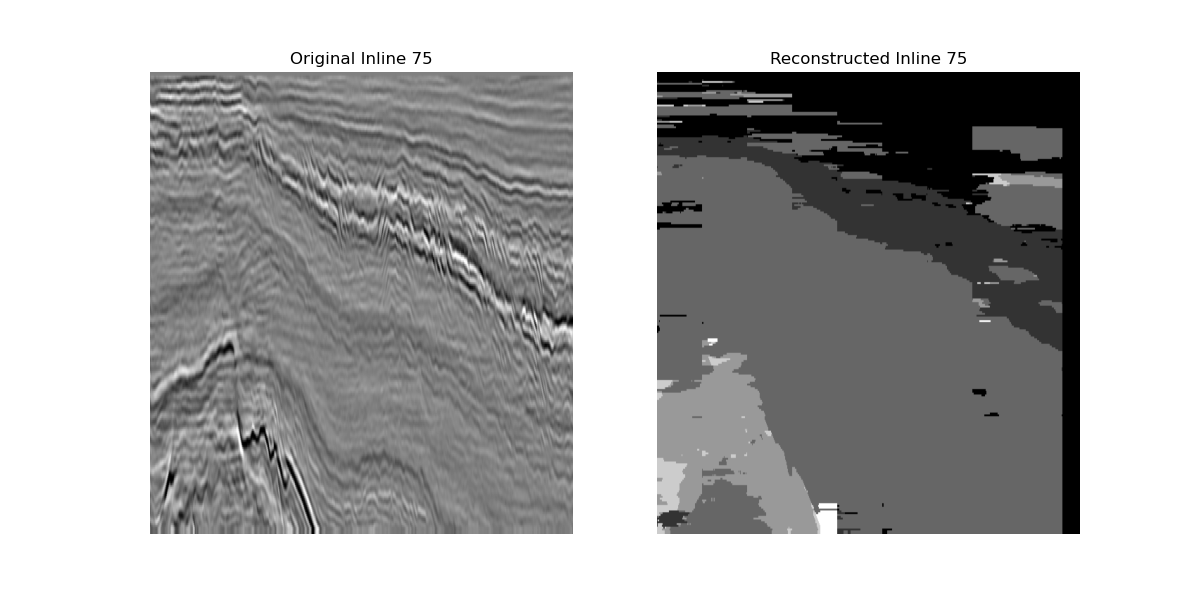

In [7]:
######################################
# visualize output predictions - inline
######################################

patch_size = (128, 128)
stride = (64, 64)  # Non-overlapping if (128,128)
original_shape = (601, 200, 255)  # shape of original dataset
inline_index = 75  # Specify an inline index to visualize
crossline_index = None  # Set to None if visualizing an inline slice

reconstructed_volume_inline = reconstruct_from_patches(predicted_lithofaciesV3, original_shape, patch_size, stride)
plot_sections(test2_seismic, reconstructed_volume_inline, inline=inline_index, crossline=crossline_index)

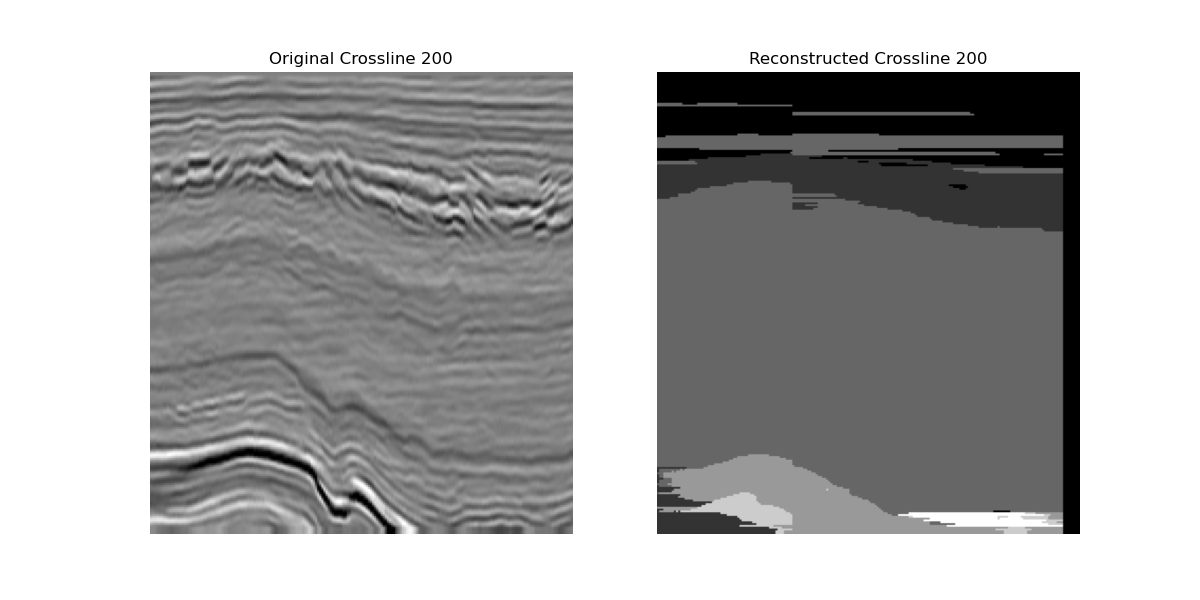

In [8]:
##########################################
# visualize output predictions - crossline
##########################################

patch_size = (128, 128)
stride = (64, 64)  # Non-overlapping if (128,128)
original_shape = (601, 200, 255)  # shape of original dataset
inline_index = None  # Specify an inline index to visualize
crossline_index = 200  # Set to None if visualizing an inline slice

reconstructed_volume_crossline = reconstruct_from_patches(predicted_lithofaciesV3, original_shape, patch_size, stride)
plot_sections(test2_seismic, reconstructed_volume_crossline, inline=inline_index, crossline=crossline_index)

## To visualize, slide bar to see different images and their predicted lithofacies. This can be done in inline, crossline, and depth.

### The following predictions can be switched in to the lithofacies_prediction variable:
- reconstructed_volume_crossline
- reconstructed_volume_inline
- reconstructed_volume_depth

### The following flag can be chosen to visualize in each direction:
- 0 for inline
- 1 for crossline
- 2 for depth slicing

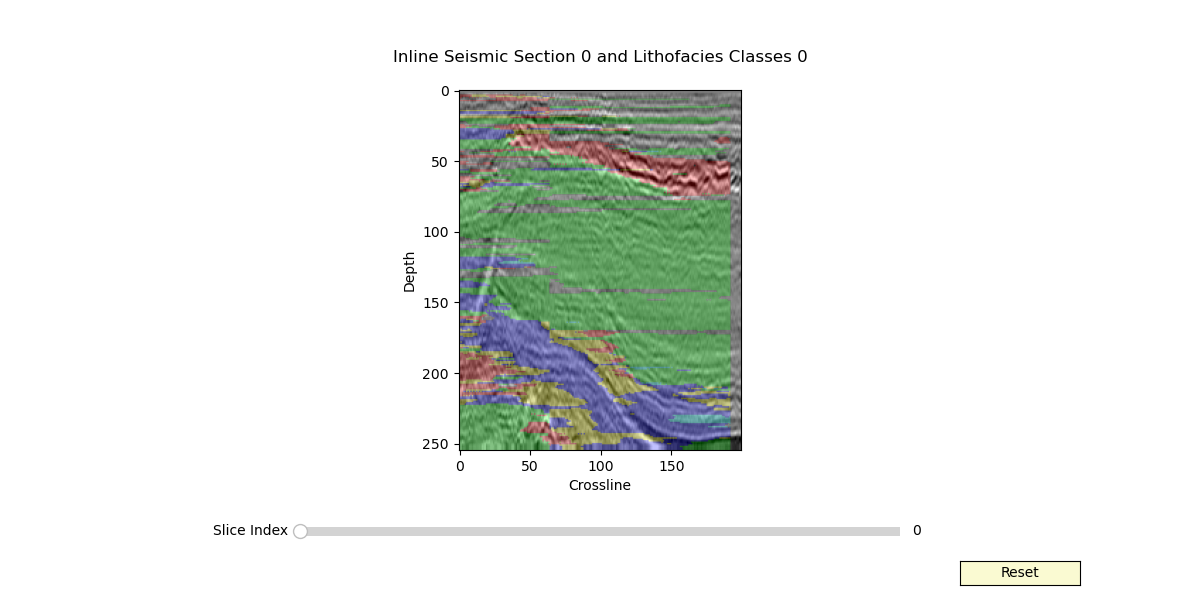

In [28]:
################################################
# Visualizations of seismic data and lithofacies
################################################
# The following datasets can be switched in to the lithofacies_prediction variable:
    # reconstructed_volume_crossline
    # reconstructed_volume_inline
    # reconstructed_volume_depth
flag = 0 # 0 for inline, 1 for crossline, 2 for depth slicing
lithofacies_prediction = reconstructed_volume_inline
viewer = vlm_slicer_interactive(test2_seismic, lithofacies_prediction, flag)  


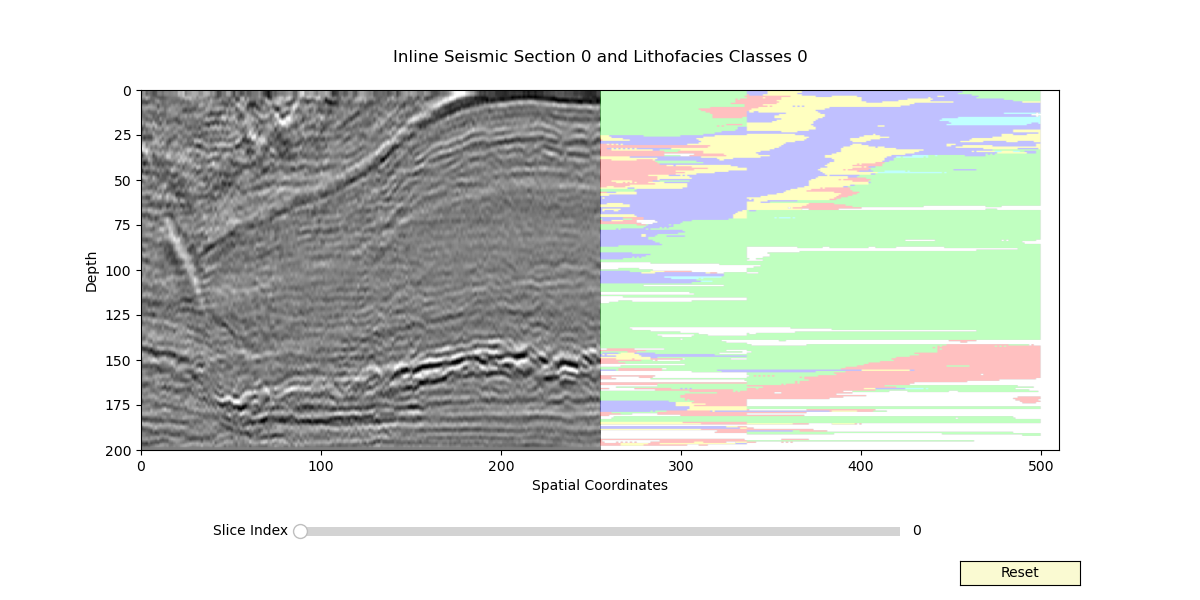

In [34]:
lithofacies_prediction = reconstructed_volume_inline
viewer = vlm_slicer_interactive2(test2_seismic, lithofacies_prediction, 0)  # 0 for inline, 1 for crossline, 2 for depth slicing

# Conclusions

To improve this model, we would first start with training more epochs, as it's currently undertrained. After doing this, we would evaluate using other performance metrics, including recall, IoU, Dice coefficients. additionally, creating more augmented data or generating our own data using the GAN or rock physics could be useful. Finally, testing transformer layers and various architectures in concert with the U-Net could improve performance.

Other models that could be tried here include the contrastive learning model, with no labels but seismic data and attributes including guiding learning.